# Playing around with popular nonlinear classification algorithms

In the next Python cell we load in several necessary libraries.

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact
from ipywidgets import widgets
import time
from IPython import display
import math
import tensorflow.contrib.learn.python.learn as learn
from sklearn import datasets, metrics
import math
import pickle
from sklearn.neural_network import MLPClassifier

# a general purpose function for running and plotting the result of a user-defined input classification algorithm
class show_net_transform():
    ###### initialization and operation testing functions ######
    def __init__(self):
        # set number of slides for linear / nonlinear transformation
        self.lin_trans_pts = 100
        self.nonlin_trans_pts = 200
        
        # setup alphas 
        self.alphas = np.zeros((self.lin_trans_pts + self.nonlin_trans_pts,))
        for i in range(self.lin_trans_pts):
            self.alphas[i] = 1
        self.alphas[self.lin_trans_pts:self.lin_trans_pts+self.lin_trans_pts] = np.linspace(0,0.9,self.lin_trans_pts)
        self.alphas[self.lin_trans_pts+self.lin_trans_pts:] = np.linspace(0.9,1,self.nonlin_trans_pts - self.lin_trans_pts)
        
        # setup range for net weights
        weights = pickle.load( open( "files/net_weights.p", "rb" ) )
        self.biases = weights[0]
        self.coeffs = weights[1]
        
        self.b1_range = 0
        self.b2_range = 0
        self.coeffs1_range = 0
        self.coeffs2_range = 0
        
        # make range of coefficients for slider
        self.make_coeff_range()
        
        # load in rule
        self.rule = np.asarray(pd.read_csv('files/nonlinear_rule.csv',header = None))

        # data variables
        data = np.asarray(pd.read_csv('files/test_data.csv',header = None))
        self.X = data[:,0:2]
        self.y = data[:,2]
        
        # load in adjustable grid
        self.adj_grid = np.asarray(pd.read_csv('files/adjustable_grid.csv',header = None))
    
    # get final parameters of trained net
    def make_coeff_range(self):
        # load in weights from trained net
        test_coeffs = self.coeffs
        test_bias = self.biases

        bias1 = test_bias[0][0]
        bias2 = test_bias[0][1]

        coeffs1 = np.asarray([test_coeffs[0][0][0],test_coeffs[0][1][0]])
        coeffs1.shape = (2,1)

        coeffs2 = np.asarray([test_coeffs[0][0][1],test_coeffs[0][1][1]])
        coeffs2.shape = (2,1)
        
        ## make range of values leading up to net weights for transition
        # for both biases
        a = np.linspace(0,bias1,self.lin_trans_pts)
        a.shape = (len(a),1)
        b = bias1*np.ones((self.nonlin_trans_pts,1))
        self.b1_range = np.concatenate((a,b),axis = 0)
        
        a = np.linspace(0,bias2,self.lin_trans_pts)
        a.shape = (len(a),1)
        b = bias2*np.ones((self.nonlin_trans_pts,1))
        self.b2_range = np.concatenate((a,b),axis = 0)

        # for coeffs1
        a = np.linspace(1,coeffs1[0],self.lin_trans_pts)
        a.shape = (len(a),1)
        b = np.linspace(0,coeffs1[1],self.lin_trans_pts)
        b.shape = (len(b),1)
        c = np.concatenate((a,b),axis = 1)
        d = a[-1]*np.ones((self.nonlin_trans_pts,1))
        e = b[-1]*np.ones((self.nonlin_trans_pts,1))
        f = np.concatenate((d,e),axis = 1)
        self.coeffs1_range = np.concatenate((c,f),axis = 0)
        
        # for coeffs2
        a = np.linspace(0,coeffs2[0],self.lin_trans_pts)
        a.shape = (len(a),1)
        b = np.linspace(1,coeffs2[1],self.lin_trans_pts)
        b.shape = (len(b),1)
        c = np.concatenate((a,b),axis = 1)
        d = a[-1]*np.ones((self.nonlin_trans_pts,1))
        e = b[-1]*np.ones((self.nonlin_trans_pts,1))
        f = np.concatenate((d,e),axis = 1)
        self.coeffs2_range = np.concatenate((c,f),axis = 0)
        
    # make data and nonlinear net rule, save data, weights, and rule
    def make_pts(self):
        # grab coeffecients 
        bias1 = self.biases[0][0]
        bias2 = self.biases[0][1]

        coeffs1 = np.asarray([self.coeffs[0][0][0],self.coeffs[0][1][0]])
        coeffs2 = np.asarray([self.coeffs[0][0][1],self.coeffs[0][1][1]])

        outer_weights = np.asarray([self.coeffs[1][0],self.coeffs[1][1]])
        outer_weights.shape = (len(outer_weights),1)
        outer_bias = self.biases[1]

        ## plot separator(s), and fuse individual subproblem separators into one joint rule
        r = np.linspace(-5.1,5.1,400)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)
        
        ## transform space - each axes - via net transform    
        # transform using basis element 1        
        f = bias1 + np.dot(h,coeffs1)
        f1 = np.tanh(f)
        f1.shape = (len(f1),1)

        # transform using basis element 2
        f = bias2 + np.dot(h,coeffs2)
        f2 = np.tanh(f)
        f2.shape = (len(f2),1)

        # cut the space to make this rule
        f = np.concatenate((f1,f2),axis = 1)
        z = outer_bias + np.dot(f,outer_weights)
        z = (np.sign(z))

        # show rule 
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        a = plt.contour(s,t,z,colors = 'k',linewidths = 2.5)

        # grab coordinates of nonlinear rule (associated with weights) and save
        p = a.collections[0].get_paths()[0]
        v = p.vertices
        x = v[:,0]
        x.shape = (len(x),1)
        y = v[:,1]
        y.shape = (len(y),1)
        data = np.concatenate((x,y),axis = 1)
        data = pd.DataFrame(data)
        data.to_csv('files/nonlinear_rule.csv',header = False,index = None)

        ### you need to just build a fucking dataset yourself
        # make random dataset
        num_pts = 200
        X = -5 + 10*np.random.rand(num_pts,2)

        ## make labels based on point location
        # transform using basis element 1        
        f = bias1 + np.dot(X,coeffs1)
        f1 = np.tanh(f)
        f1.shape = (len(f1),1)

        # transform using basis element 2
        f = bias2 + np.dot(X,coeffs2)
        f2 = np.tanh(f)
        f2.shape = (len(f2),1)

        f = np.concatenate((f1,f2),axis = 1)
        z = outer_bias + np.dot(f,outer_weights)

        ind0 = np.argwhere(z <= 0)
        ind0 = [s[0] for s in ind0]
        ind1 = np.argwhere(z > 0)
        ind1 = [s[0] for s in ind1]

        y = np.zeros((num_pts,1))
        y[ind0] = -1
        y[ind1] = 1

        # plot data
        red = [0.25,1,0.5]    # custom color for plotting purposes
        green = [1,0.3,0.3]   # custom color for plotting purposes
        plt.scatter(X[ind0,0],X[ind0,1],s = 50, color = green, edgecolor = 'k')
        plt.scatter(X[ind1,0],X[ind1,1],s = 50, color = red, edgecolor = 'k')

        # data and labels
        data = np.concatenate([X,y],axis = 1)
        data = pd.DataFrame(data)
        data.to_csv('files/test_data.csv',header = False,index = None)
       
    # make the adjustable grid
    def make_warpable_grid():
        s = np.linspace(-10,10,40)
        s.shape = (len(s),1)
        g = np.array([-10,-10])
        g.shape = (1,len(g))
        e = np.linspace(-10,10,200)
        e.shape = (len(e),1)
        f = np.ones((200,1))
        f.shape = (len(f),1)
        for a in s:
            t = a*f
            h = np.concatenate((e,t),axis = 1)
            i = np.concatenate((t,e),axis = 1)
            j = np.concatenate((h,i),axis = 0)
            g = np.concatenate((g,j),axis = 0)

        g = g[1:,:]
        g = pd.DataFrame(g)
        g.to_csv('files/adjustable_grid.csv',header = False,index = None) 
    
    # illustrate tanh approx from linear using slider
    def show_tanh_approx(self):
        s = np.linspace(-10,10,1000)
        def show_fit(alpha):
            func = (1-alpha/float(200))*s + alpha/float(200)*np.tanh(s)
            plt.plot(s,func)
            plt.ylim([-5,5])

        interact(show_fit, alpha=widgets.IntSlider(min=0,max=200),step=1,value=0)
        
    ###### plotting functions ######
    # plot all points and clean up plot
    def plot_pts(self,X,rule):
        # plot our points
        red = [0.25,1,0.5]    # custom color for plotting purposes
        green = [1,0.3,0.3]   # custom color for plotting purposes
        plt.scatter(X[np.argwhere(self.y == -1).flatten(),0],X[np.argwhere(self.y==-1).flatten(),1],s = 50, color = green, edgecolor = 'k',zorder = 2)
        plt.scatter(X[np.argwhere(self.y==1).flatten(),0],X[np.argwhere(self.y==1).flatten(),1],s = 50, color = red, edgecolor = 'k',zorder = 2)
        plt.plot(rule[:,0],rule[:,1],color = 'k',linewidth = 3,zorder = 3)
        
        # dress panel correctly with axis labels etc.
        plt.yticks([],[])
        plt.axis('off')  
        xlen = max(X[:,0]) - min(X[:,0])
        ylen = max(X[:,1]) - min(X[:,1])
        plt.xlim([min(X[:,0]) - xlen/float(5),max(X[:,0]) + xlen/float(5)])
        plt.ylim([min(X[:,1]) - ylen/float(5),max(X[:,1]) + ylen/float(5)])
        plt.grid(False)

    # plot perfectly transformed data
    def plot_final_transform(self):
        bias1 = self.b1_range[-1]
        bias2 = self.b2_range[-1]

        coeffs1 = self.coeffs1_range[-1]
        coeffs2 = self.coeffs2_range[-1]
        
        # transform using basis element 1
        f = bias1 + np.dot(self.X,coeffs1)
        f1 = np.tanh(f)
        f1.shape = (len(f1),1)

        # transform using basis element 2
        f = bias2 + np.dot(self.X,coeffs2)
        f2 = np.tanh(f)
        f2.shape = (len(f2),1)

        X_tr = np.concatenate((f1,f2),axis = 1)
        
        # transform using basis element 1        
        f = bias1 + np.dot(self.rule,coeffs1)
        f1 = np.tanh(f)
        f1.shape = (len(f1),1)

        # transform using basis element 2
        f = bias2 + np.dot(self.rule,coeffs2)
        f2 = np.tanh(f)
        f2.shape = (len(f2),1)

        rule_tr = np.concatenate((f1,f2),axis = 1)
        
        # plot results
        self.plot_pts(X_tr,rule_tr)
        
    # plot prediction
    def plot_prediction(self):
        # plot classification boundary and color regions appropriately
        red = [0.25,1,0.5]    # custom color for plotting purposes
        green = [1,0.3,0.3]   # custom color for plotting purposes
        r = np.linspace(-0.1,1.1,300)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),1)

        # use classifier to make predictions
        z = self.clf.predict(h)

        # reshape predictions for plotting
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))

        # show the filled in predicted-regions of the plane 
        plt.contourf(s,t,z,colors = [green,red],alpha = 0.2,levels = range(-1,2))

        # show the classification boundary if it exists
        if len(np.unique(z)) > 1:
            plt.contour(s,t,z,colors = 'k',linewidths = 2)
       
    ###### main functions ######
    # transform data by shoving it through network
    def transform_data(self,X,p):
        # setup parameters
        bias1 = self.b1_range[p]
        bias2 = self.b2_range[p]

        coeffs1 = self.coeffs1_range[p]
        coeffs2 = self.coeffs2_range[p]
        
        alpha = self.alphas[p]
        
        # transform using basis element 1
        s = (bias1 + np.dot(X,coeffs1))
        if p > self.lin_trans_pts:
            s = self.my_tanh(s,alpha)        
        s.shape = (len(s),1)
        
        # transform using basis element 2
        t = (bias2 + np.dot(X,coeffs2))
        if p > self.lin_trans_pts:
            t = self.my_tanh(t,alpha)
        t.shape = (len(t),1)

        X_tr = np.concatenate((s,t),axis = 1)
        
        return X_tr        
    
    # use convex combo of y = x and y = tanh(x) to transition from linear --> nonlinear part of net operation
    def my_tanh(self,data,alpha):            
        approx = (1 - alpha)*data + alpha*np.tanh(data)
        return approx
    
    # show the net transformation using slider
    def show_transform(self):    
        def show_fit(p):
            X_tr = self.transform_data(self.X,p)
            rule_tr = self.transform_data(self.rule,p)
            grid_tr = self.transform_data(self.adj_grid,p)

            # plot points and rule
            self.plot_pts(X_tr,rule_tr)
                   
            # plot adjustble grid
            for i in range(80):
                plt.plot(grid_tr[200*i:(i+1)*200,0],grid_tr[200*i:(i+1)*200,1],color = [0.75,0.75,0.75],linewidth = 1,zorder = 1)   

        interact(show_fit, p=widgets.IntSlider(min=0,max=self.lin_trans_pts + self.nonlin_trans_pts-1,step=1,value=0))

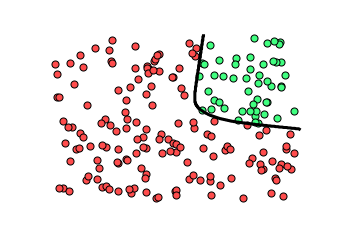

In [98]:
test = show_net_transform()
test.plot_pts(test.X,test.rule)

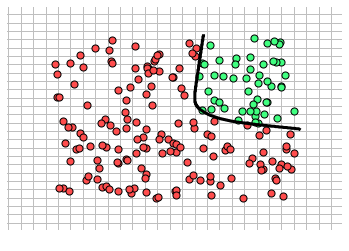

In [99]:
test.show_transform()